# Introduction

The number of reads indicates how well a cell can grow when it has a transposon inserted in a specific genomic region.
This can be converted to a fitness level, similarly as was done in [Costanzo et.al. 2013](https://experts.umn.edu/en/publications/genetic-networks).
Potentially this can be used to determine interaction (and whether they are positive or negative) between genes.
This can be done by using two datasets resulting from SATAY experiments, one wild type and one deletion strain.
From the wild type, the fitness can be determined for two genes that have a transposon insertion, called A and B (which corresponds to two single deletions, $\Delta$A and $\Delta$B).
Next, the deletion strain from $\Delta$B is measured as well using SATAY.
From this deletion strain, the fitness can be determined for a transposon insertion in gene A (basically creating a double deletion $\Delta$A$\Delta$B).
The expected fitness based on the fitness A and B from the wild type SATAY experiments (where fitness is defined as *a* and *b* respectively) is equal to the multiplication of the indivual fitnesses (*a* times *b*) and the actual fitness can be determined based on the SATAY experiments from the $\Delta$B strain (defined as *ab*).
The difference between the expected fitness and the actual fitness indicates possible interactions between the genes A and B (thus the intercation score = *ab* - *a* times *b*).
If the difference is positive (meaning that the actual fitness is higher than the expected fitness), there is positive interaction and when the difference is negative (actual fitness is lower than the expected fitness) there is negative interaction.

To estimate the fitness of the cells, the reads needs to be normalized.
This has to be done with a certain caution, since the likelyhood of a transposon insertion is not constant throughout the genome or within a chromosome.
This file is created to test several normalization methods.

The current method is to define the several windows, based on regions where there are many or few reads.
Each of these windows are normalized individually independent of the other windows.
The normalization is done based on the neutral genomic regions, which are regions that do not code for genes or other features that might influence the fitness of the cells when they are inhibited by a transposon insertion.
This creates a relative flat distribution where locations with few reads correspond to important (or potentially essential) genomic regions.
Similarly, locations with many reads correspond to regions that are not important for proliferation.



## The code

The code relies on the packages loaded in the first cell of this notebook.
The user settings are in the second cell (for a brief explanation, see below).
There are some additional files that are loaded (see cell 3), for which the location is defined using the relative path of this script.
For first time use, check if the relative path to the files is correct.

### Input
- Chromosome number: given in roman numerals between 'I' and 'XVI'
- wig_file: Output from the transposonmapping.py code used in the SATAY processing pipeline
- pergene_insertions_file: Output from the transposonmapping.py code used in the SATAY processing pipeline
- variable: either "reads" or "transposons", indicate what needs to be plotted (NOTE: normalization is only defined for the number of reads, since the reads can be used to determine the fitness level)
- normalize: boolean, whether the data needs to be normalized to output the fitness level rather than the actual number of reads per transposon per genomic region.

### Output
graph indicating the genomic regions and the number of reads or transposons per basepair per genomic region (or the fitness per genomic region if normalization is set to True).
The width of bars is variable depending on the width of the genomic region it represents.

In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


file_dirname = os.path.dirname(os.path.abspath('__file__'))
sys.path.insert(1,os.path.join(file_dirname,'..','python_modules'))
from chromosome_and_gene_positions import chromosome_position, chromosomename_roman_to_arabic
from chromosome_names_in_files import chromosome_name_wigfile
from gene_names import list_gene_names, gene_aliases
from read_sgdfeatures import sgd_features

In [2]:
region = "IX"
wig_file = r"C:\Users\gregoryvanbeek\Documents\testing_site\wt1_testfolder_S288C\align_out\ERR1533147_trimmed.sorted.bam.wig"
pergene_insertions_file = r"C:\Users\gregoryvanbeek\Documents\testing_site\wt1_testfolder_S288C\align_out\ERR1533147_trimmed.sorted.bam_pergene_insertions.txt"
variable="reads"
normalize=True

In [3]:
essentials_file = r"C:\Users\gregoryvanbeek\Documents\GitHub\LaanLab-SATAY-DataAnalysis\Python_scripts\Data_Files\Cerevisiae_AllEssentialGenes_List.txt"

gene_information_file = os.path.join(file_dirname,'..','Data_Files','Yeast_Protein_Names.txt')

gff_file = os.path.join(file_dirname,'..','Data_Files','Saccharomyces_cerevisiae.R64-1-1.99.gff3')

sgd_features_file = os.path.join(file_dirname,'..','Data_Files','SGD_features.tab')

In [4]:
if type(region) == str:
    if region in chromosomename_roman_to_arabic()[1]:
        chrom = region
        region_start = None
        region_end = None
    elif region in list_gene_names(gene_information_file):
        #LOOK UP GENE INFORMATION ...
        pass
    else:
        print("WARNING: Specified chromosome not found. Enter chromosome as a roman numeral between I and XVI")

elif type(region) == list: #ADD CODE THAT ONLY TAKES GENES WITHIN SPECIFIED REGION
    chrom = region[0]
    region_start = region[1]
    region_end = region[2]


del (region)

In [5]:
with open(wig_file, 'r') as f:
    lines = f.readlines()

chrom_start_line_dict, chrom_end_line_dict = chromosome_name_wigfile(lines)[1:]

insrt_in_chrom_list = []
reads_in_chrom_list = []
for l in lines[chrom_start_line_dict.get(chrom):chrom_end_line_dict.get(chrom)]:
    insrt_in_chrom_list.append(int(l.strip('\n').split(' ')[0]))
    reads_in_chrom_list.append(int(l.strip('\n').split(' ')[1]))


del (lines, l, f, chrom_start_line_dict, chrom_end_line_dict)

In [6]:
with open(pergene_insertions_file) as f:
    lines = f.readlines()


gene_position_dict = {}
for line in lines[1:]:
    line_split = line.strip('\n').split('\t')


    if line_split[1] == chrom:
        genename = line_split[0]
        gene_chrom = line_split[1]
        gene_start = int(line_split[2])
        gene_end = int(line_split[3])

        gene_position_dict[genename] = [gene_chrom, gene_start, gene_end] #DICT CONTAINING ALL GENES WITHIN THE DEFINED CHROMOSOME INCLUDING ITS START AND END POSITION


        geneinserts_str = line_split[4].strip('[]')
        if not geneinserts_str == '':
            geneinserts_list = [int(ins) for ins in geneinserts_str.split(',')]
        else:
            geneinserts_list = []


        genereads_str = line_split[5].strip('[]')
        if not genereads_str == '':
            genereads_list = [int(read) for read in genereads_str.split(',')]
        else:
            genereads_list = []


        if len(geneinserts_list) != len(genereads_list):
            print('WARNING: %s has different number of reads compared with the number of inserts' % genename )


del (f, lines, line, line_split, genename, gene_chrom, gene_start, gene_end, geneinserts_list, geneinserts_str, genereads_str, genereads_list)


In [7]:
len_chr = chromosome_position(gff_file)[0].get(chrom)
start_chr = chromosome_position(gff_file)[1].get(chrom)
end_chr = chromosome_position(gff_file)[2].get(chrom)

dna_dict = {} #for each bp in chromosome, determine whether it belongs to a noncoding or coding region
for bp in range(start_chr, end_chr + 1): #initialize dna_dict
    dna_dict[bp] = ['noncoding', None] #form is: ['element_name', 'type']



feature_orf_dict = sgd_features(sgd_features_file)[0]
gene_alias_dict = gene_aliases(gene_information_file)[0]

for gene in gene_position_dict:
    if gene in feature_orf_dict:
        for bp in range(gene_position_dict.get(gene)[1]+start_chr, gene_position_dict.get(gene)[2]+start_chr+1):
            dna_dict[bp] = [gene, "Gene; "+feature_orf_dict.get(gene)[1]]
    else:
        gene_alias = [key for key, val in gene_alias_dict.items() if gene in val][0]
        for bp in range(gene_position_dict.get(gene)[1]+start_chr, gene_position_dict.get(gene)[2]+start_chr+1):
            dna_dict[bp] = [gene_alias, "Gene; "+feature_orf_dict.get(gene_alias)[1]]

del (gff_file, gene, bp, gene_alias)


## determine the location of several genomic features
For example:
- genes
- telomeres
- centromeres
- ...

In [8]:
def feature_position(feature_dict, chrom, start_chr, dna_dict, feature_type=None):
    
    position_dict = {}
    for feat in feature_dict:
        if feature_dict.get(feat)[5] == chrom:
            if feat.startswith("TEL") and feat.endswith('L'): #correct for the fact that telomeres at the end of a chromosome are stored in the reverse order.
                position_dict[feat] = [feature_dict.get(feat)[5], feature_dict.get(feat)[7], feature_dict.get(feat)[6]]
            else:
                position_dict[feat] = [feature_dict.get(feat)[5], feature_dict.get(feat)[6], feature_dict.get(feat)[7]]


    for feat in position_dict:
        for bp in range(int(position_dict.get(feat)[1])+start_chr, int(position_dict.get(feat)[2])+start_chr):
            if dna_dict[bp] == ['noncoding', None]:
                dna_dict[bp] = [feat, feature_type]
            else:
                pass


    return(dna_dict)


dna_dict = feature_position(sgd_features(sgd_features_file)[1], chrom, start_chr, dna_dict, "ARS") #ARS
dna_dict = feature_position(sgd_features(sgd_features_file)[2], chrom, start_chr, dna_dict, "Telomere") #Telomeres
dna_dict = feature_position(sgd_features(sgd_features_file)[3], chrom, start_chr, dna_dict, "Centromere") #Centromeres
dna_dict = feature_position(sgd_features(sgd_features_file)[4], chrom, start_chr, dna_dict, "X_element") #X_element
dna_dict = feature_position(sgd_features(sgd_features_file)[5], chrom, start_chr, dna_dict, "ncRNA") #ncRNA
dna_dict = feature_position(sgd_features(sgd_features_file)[6], chrom, start_chr, dna_dict, "External_transcribed_Spacer_Region") #External transcribed spacer region
dna_dict = feature_position(sgd_features(sgd_features_file)[7], chrom, start_chr, dna_dict, "Internal_transcribed_Spacer_Region") #Internal transcribed spacer region


### TEST IF ELEMENTS IN FEATURE_ORF_DICT FOR SELECTED CHROMOSOME ARE THE SAME AS THE GENES IN GENE_POSITION_DICT BY CREATING THE DICTIONARY FEATURE_POSITION_DICT CONTAINING ALL THE GENES IN FEATURE_ORF_DICT WITH THEIR CORRESPONDING POSITION IN THE CHROMOSOME
gene_alias_dict = gene_aliases(gene_information_file)[0]
orf_position_dict = {}
for feature in feature_orf_dict:
    if feature_orf_dict.get(feature)[5] == chrom:
        if feature in gene_position_dict:
            orf_position_dict[feature] = [feature_orf_dict.get(feature)[6], feature_orf_dict.get(feature)[7]]
        else:
            for feature_alias in gene_alias_dict.get(feature):
                if feature_alias in gene_position_dict:
                    orf_position_dict[feature_alias] = [feature_orf_dict.get(feature)[6], feature_orf_dict.get(feature)[7]]



if sorted(orf_position_dict) == sorted(gene_position_dict):
    print('Everything alright, just ignore me!')
else:
    print('WARNING: Genes in feature_list are not the same as the genes in the gene_position_dict. Please check!')


del (sgd_features_file, feature_orf_dict, orf_position_dict, feature, feature_alias, gene_position_dict)


Everything alright, just ignore me!


In [9]:
reads_loc_list = [0] * len(dna_dict) # CONTAINS ALL READS JUST LIKE READS_IN_CHROM_LIST, BUT THIS LIST HAS THE SAME LENGTH AS THE NUMBER OF BP IN THE CHROMOSOME WHERE THE LOCATIONS WITH NO READS ARE FILLED WITH ZEROS
i = 0
for ins in insrt_in_chrom_list:
    reads_loc_list[ins] = reads_in_chrom_list[i]
    i += 1

del (i, ins, insrt_in_chrom_list, reads_in_chrom_list)#, dna_df)

## Create dataframe
The next section creates the dataframe dna_df2, which includes all information gathered from the data.

In [10]:
feature_NameAndType_list = []
f_previous = dna_dict.get(start_chr)[0]
f_type = dna_dict.get(start_chr)[1]
N_reads = 0
N_reads_list = []
N_insrt = 0
N_insrt_list = []
N_bp = 1
N_bp_list = []
f_start = 0
f_end = 0
f_pos_list = []
i = 0
for bp in dna_dict:
    f_current = dna_dict.get(bp)[0]
    if f_current == f_previous:
        f_type = dna_dict.get(bp)[1]
        f_end += 1
        N_bp += 1
        N_reads += reads_loc_list[i]
        if not reads_loc_list[i] == 0:
            N_insrt += 1
    elif (f_current != f_previous or (i+start_chr) == end_chr):# and not f_current.endswith('-A'):
        feature_NameAndType_list.append([f_previous, f_type])
        N_reads_list.append(N_reads)
        N_insrt_list.append(N_insrt)
        N_bp_list.append(N_bp)
        N_reads = 0
        N_insrt = 0
        N_bp = 1
        f_pos_list.append([f_start, f_end+f_start])
        f_start = f_start + f_end + 1
        f_end = 0
        f_previous = f_current
    i += 1

N_reads_per_bp_list = []
N_insrt_per_bp_list = []
for i in range(len(N_reads_list)):
    N_reads_per_bp_list.append(N_reads_list[i]/N_bp_list[i])
    N_insrt_per_bp_list.append(N_insrt_list[i]/N_bp_list[i])


#############get all essential genes together with their aliases##############
with open(essentials_file, 'r') as f:
    essentials_temp_list = f.readlines()[1:]
essentials_list = [essential.strip('\n') for essential in essentials_temp_list]
del essentials_temp_list

gene_alias_dict = gene_aliases(gene_information_file)[0]
for key, val in gene_alias_dict.items():
    if key in essentials_list:
        for alias in val:
            essentials_list.append(alias)

#ADD
essentiality_list = []
for feature in feature_NameAndType_list:
    if not feature[0] == "noncoding":
        if feature[1] == "ARS" or feature[1] == "Telomere" or feature[1] == "Centromere" or feature[1] == "X_element" or feature[1] == "ncRNA" or feature[1] == "External_transcribed_Spacer_Region" or feature[1] == "Internal_transcribed_Spacer_Region":
            essentiality_list.append(None)
        elif feature[0] in essentials_list:
            essentiality_list.append(True)
        else:
            essentiality_list.append(False)
    else:
        essentiality_list.append(None)

del (key, val, alias, essentials_list, feature, gene_alias_dict, gene_information_file, reads_loc_list)
##############################################################################

feature_name_list = []
feature_type_list = []
for feature_name in feature_NameAndType_list:
    feature_name_list.append(feature_name[0])
    feature_type_list.append(feature_name[1])

all_features = {'Feature': feature_name_list,
                'Feature_type': feature_type_list,
                'Essentiality': essentiality_list,
                'position': f_pos_list,
                'Nbasepairs':N_bp_list,
                'Ninsertions':N_insrt_list,
                'Nreads':N_reads_list,
                'Ninsertionsperbp':N_insrt_per_bp_list,
                'Nreadsperbp':N_reads_per_bp_list}

dna_df2 = pd.DataFrame(all_features, columns = [column_name for column_name in all_features]) #search for feature using: dna_df2.loc[dna_df2['Feature'] == 'CDC42']
#CREATE NEW COLUMN WITH ALL DOMAINS OF THE GENE (IF PRESENT) AND ANOTHER COLUMN THAT INCLUDES LISTS OF THE BP POSITIONS OF THESE DOMAINS


del (dna_dict, feature_NameAndType_list, feature_name_list, feature_type_list, feature_name, f_type, f_previous, f_start, f_end, f_pos_list, f_current, N_reads, N_reads_list, N_insrt, N_insrt_list, N_bp, N_bp_list, bp, i, N_reads_per_bp_list, N_insrt_per_bp_list, all_features, essentiality_list, essentials_file)


## Normalize
The next section normalizes the data.
This part is under construction and does still needs to be checked, so do not fully rely on the results.

In [11]:
if normalize == True: #remove outliers before normalization using: dna_df2.at[273, "Nreadsperbp"] = 0

    # DETERMINE MEANS FOR THE NUMBER OF READS/BP IN THE NONCODING REGIONS WITHIN EACH WINDOW.
    window_edge_list = np.linspace(0, len_chr, 10).tolist()#[82500, 243500, len_chr]


    dna_df2["Nreadsperbp_Norm"] = list(dna_df2["Nreadsperbp"])
    reads_list = []
    window_start_index = 0
    mean_per_window_list = []
    for edge in window_edge_list[1:]:
        for index, row in dna_df2.iterrows():
            if row["Feature"] == "noncoding":
                if row["position"][0] >= window_start_index and row["position"][0] < edge:
                    reads_list.append(row["Nreadsperbp_Norm"])
                elif row["position"][0] > edge:
                    mean_per_window_list.append(np.mean(reads_list))
                    reads_list = [] #reset list for next window
                    reads_list.append(row["Nreadsperbp_Norm"]) #add current read
                    window_start_index = edge
                    break
    mean_per_window_list.append(np.mean(reads_list)) #get mean for reads in last window

    del (edge, index, row, reads_list, window_start_index)


    # NORMALIZE ALL REGIONS WITHIN THE WINDOWS WITH THEIR RESPECTIVE VALUES STORED IN MEAN_PER_WINDOW_LIST.
    window_start_index = 0
    i = 0
    for edge in window_edge_list[1:]:
        for index, row in dna_df2.iterrows():
            if row["position"][0] >= window_start_index and row["position"][0] < edge:
                dna_df2.at[index, "Nreadsperbp_Norm"] = row["Nreadsperbp_Norm"]/mean_per_window_list[i]
            elif row["position"][0] > edge:
                window_start_index = edge
                i += 1
                break

    del (window_edge_list, edge, window_start_index ,i, index, row, mean_per_window_list)


    print("Before normalization: Mean reads/bp = %.2f +/- %.2f" % (np.mean(dna_df2["Nreadsperbp"]), np.std(dna_df2["Nreadsperbp"])))
    print("After normalization: Mean reads/bp  = %.2f +/- %.2f" % (np.mean(dna_df2["Nreadsperbp_Norm"]), np.std(dna_df2["Nreadsperbp_Norm"])))


    max_readspertn = dna_df2["Nreadsperbp_Norm"].max()
    dna_df2["Nreadsperbp_Norm"] /= max_readspertn

    del (max_readspertn)

Before normalization: Mean reads/bp = 0.79 +/- 2.09
After normalization: Mean reads/bp  = 0.69 +/- 1.19


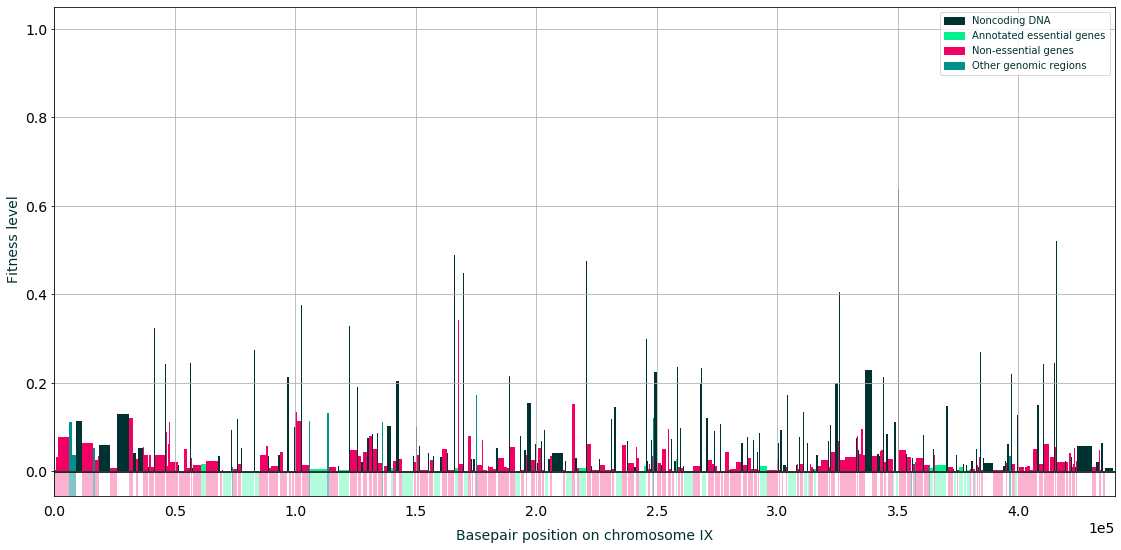

In [13]:
noncoding_color = "#003231"
essential_color = "#00F28E"
nonessential_color = "#F20064"
codingdna_color = '#00918f'
textcolor = "#003231"
textsize = 14



feature_middle_pos_list = []
sum_bp = 0
for x in dna_df2['Nbasepairs']:
    feature_middle_pos_list.append(x/2 + sum_bp)
    sum_bp += x
del (x, sum_bp)

feature_width_list = list(dna_df2['Nbasepairs'])


barcolor_list = []
for feature in dna_df2['Feature']:
    if feature == 'noncoding':
        barcolor_list.append(noncoding_color)
    elif dna_df2.loc[dna_df2['Feature'] == feature]['Essentiality'].iloc[0] == False:
        barcolor_list.append(nonessential_color)
    elif dna_df2.loc[dna_df2['Feature'] == feature]['Essentiality'].iloc[0] == True:
        barcolor_list.append(essential_color)
    elif dna_df2.loc[dna_df2['Feature'] == feature]['Essentiality'].iloc[0] == None:
        barcolor_list.append(codingdna_color)
del (feature)




###PLOTTING
fig = plt.figure(figsize=(19,9))
grid = plt.GridSpec(20, 1, wspace=0.0, hspace=0.01)


ax = plt.subplot(grid[0:19,0])
if variable == "insertions":
    ax.bar(feature_middle_pos_list, list(dna_df2['Ninsertionsperbp']), feature_width_list, color=barcolor_list)
    ax.set_ylabel("Transposons/bp per region", fontsize=textsize, color=textcolor)
elif variable == "reads":
    ax.bar(feature_middle_pos_list, list(dna_df2['Nreadsperbp_Norm']), feature_width_list, color=barcolor_list)
    ax.set_ylabel("Fitness level", fontsize=textsize, color=textcolor)

if region_start != None and region_end != None and region_start < len_chr and region_end < len_chr:
    ax.set_xlim(region_start, region_end)
else:
    ax.set_xlim(0, len_chr)

ax.grid(linestyle='-', alpha=1.0)
ax.tick_params(labelsize=textsize)
ax.tick_params(axis='x', which='major', pad=30)
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax.xaxis.get_offset_text().set_fontsize(textsize)
ax.set_xlabel("Basepair position on chromosome "+chrom, fontsize=textsize, color=textcolor, labelpad=10)
legend_noncoding = mpatches.Patch(color=noncoding_color, label="Noncoding DNA")
legend_essential = mpatches.Patch(color=essential_color, label="Annotated essential genes")
legend_nonessential = mpatches.Patch(color=nonessential_color, label="Non-essential genes")
legend_coding = mpatches.Patch(color=codingdna_color, label="Other genomic regions")
leg = ax.legend(handles=[legend_noncoding, legend_essential, legend_nonessential, legend_coding]) #ADD
for text in leg.get_texts():
    text.set_color(textcolor)
del text


axc = plt.subplot(grid[19,0])
ess_start_pos_list = []
ness_start_pos_list = []
ess_end_pos_list = []
ness_end_pos_list = []
l = 0
counter = 0
for width in feature_width_list:
    if dna_df2.loc[counter][2] == True:
        axc.axvspan(l,l+width,facecolor=essential_color,alpha=0.3)
    elif dna_df2.loc[counter][2] == False and not dna_df2.loc[counter][0] == 'noncoding':
        axc.axvspan(l,l+width,facecolor=nonessential_color,alpha=0.3)
    elif dna_df2.loc[counter][2] == None and not dna_df2.loc[counter][0] == 'noncoding':
        axc.axvspan(l,l+width,facecolor=codingdna_color,alpha=0.5)
    l += width
    counter += 1
if region_start != None and region_end != None and region_start < len_chr and region_end < len_chr:
    axc.set_xlim(region_start, region_end)
else:
    axc.set_xlim(0, len_chr)
axc.tick_params(labelsize=textsize)
axc.set_yticklabels([])
axc.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

axc.tick_params(
    axis='y',          # changes apply to the y-axis
    which='both',      # both major and minor ticks are affected
    left=False,        # ticks along the bottom edge are off
    right=False,       # ticks along the top edge are off
    labelleft=False)   # labels along the bottom edge are off

del (barcolor_list, codingdna_color, essential_color, feature_middle_pos_list, feature_width_list, noncoding_color, nonessential_color, textcolor, textsize, ess_start_pos_list, ness_start_pos_list, ess_end_pos_list, ness_end_pos_list, l, counter, width)


# References

- Costanzo, M., Baryshnikova, A., VanderSluis, B., Andrews, B., Myers, C. L., & Boone, C. (2013). Genetic networks. In Handbook of Systems Biology (pp. 115-135). Elsevier Inc..